In [118]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt

Đường dẫn data

In [119]:
data_original_Path = '../Data/originalData/data_original_new.csv'
data_project_Path = '../Data/originalData/data_project_new.csv'

Đọc file và phân loại

In [120]:
df = pd.read_csv(data_original_Path)  

df['Loại bất động sản'] = df['Phân loại'].apply(lambda x: x.split(' tại ')[0])


Tính tổng giá, tổng số lượng mỗi loại bđs 
--->Tính giá trung bình mỗi loại

In [121]:
def extract_last_price_number(history):
    # Tách các giá trị trong lịch sử, chọn giá trị cuối cùng
    prices = history.split(';')
    
    filtered_prices = [price.strip() for price in prices if price.strip()]

    if filtered_prices:
      last_price = filtered_prices[-1]
    if last_price == 'Không có dữ liệu lịch sử giá':
       return '0'
    
    return last_price.split()[-2].replace(',', '.')
# Thêm cột "Giá cuối cùng" vào DataFrame
df['Giá cuối cùng'] = df['Lịch sử giá'].apply(extract_last_price_number)

# Tạo danh sách các cặp
result = [(row['Loại bất động sản'], row['Giá cuối cùng']) 
          for _, row in df.iterrows()
          if float(row['Giá cuối cùng']) != 0
]

total_price = {}
count_classify = {}
avg_price = {}

# Chuyển thành định dạng chuỗi như bạn yêu cầu
for loai_bds, gia_cuoi in result:
    if loai_bds in total_price:
        total_price[loai_bds] += float(gia_cuoi)
        count_classify[loai_bds] += 1
    else:
        total_price[loai_bds] = float(gia_cuoi)
        count_classify[loai_bds] = 1

avg_price = {
    key: (total_price[key] / count_classify[key]) if count_classify[key] > 0 else 0
    for key in total_price.keys()
}



Vẽ biểu đồ cột giá trung bình từng loại hình bất động sản tại Hà Nội

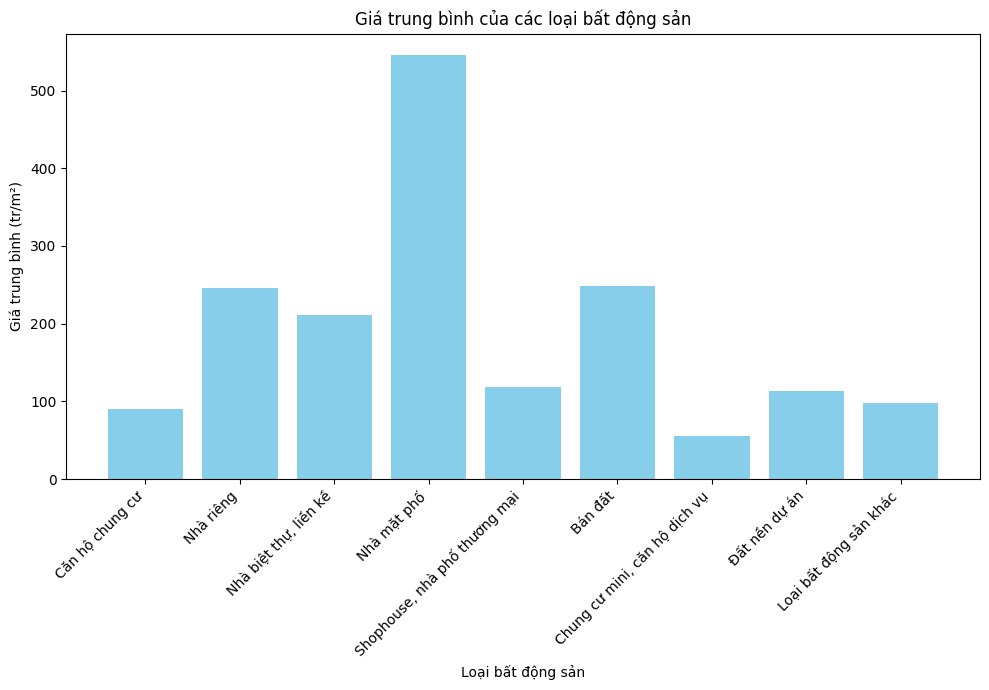

In [122]:
temp = avg_price.pop("Loại bất động sản khác")  # Loại bỏ và lưu giá trị
avg_price["Loại bất động sản khác"] = temp

classify = list(avg_price.keys())
price_of_classify = list(avg_price.values())

# Tạo biểu đồ cột
plt.figure(figsize = (10, 7))  
plt.bar(classify, price_of_classify, color = 'skyblue')  
plt.xlabel('Loại bất động sản')  
plt.ylabel('Giá trung bình (tr/m²)')  
plt.title('Giá trung bình của các loại bất động sản')  
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()  

# Hiển thị biểu đồ
plt.show()

Phân loại data dự án và vẽ số lượng của từng loại dự án

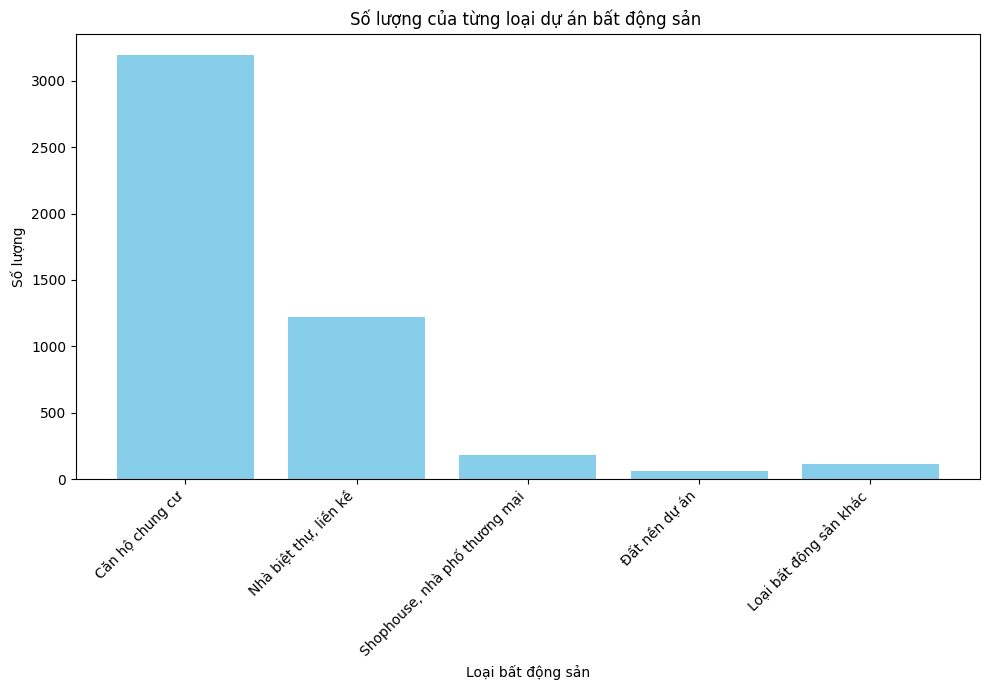

In [123]:
df_project = pd.read_csv(data_project_Path)  

df_project['Loại bất động sản'] = df_project['Phân loại'].apply(lambda x: x.split(' tại ')[0])

number_of_classify = df_project.groupby('Loại bất động sản').size()
number_of_classify = number_of_classify.drop(['Bán đất', 'Chung cư mini, căn hộ dịch vụ','Condotel', 'Nhà mặt phố', 'Nhà riêng'])

temp = number_of_classify["Loại bất động sản khác"]  # Lưu giá trị của hàng này
number_of_classify = number_of_classify.drop("Loại bất động sản khác")  # Loại bỏ khỏi Series
number_of_classify["Loại bất động sản khác"] = temp  # Thêm lại vào cuối

classify_project = number_of_classify.index
count_of_classify = number_of_classify.tolist()


# Tạo biểu đồ cột
plt.figure(figsize = (10, 7))  
plt.bar(classify_project, count_of_classify, color = 'skyblue')  
plt.xlabel('Loại bất động sản')  
plt.ylabel('Số lượng')  
plt.title('Số lượng của từng loại dự án bất động sản ')  
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()  

# Hiển thị biểu đồ
plt.show()


Làm sạch dữ liệu lịch sử giá

In [124]:
# Lọc các bản ghi có giá trị trong cột 'Lịch sử giá'
df_filtered = df[df['Lịch sử giá'].notnull() & (df['Lịch sử giá'] != "Không có dữ liệu lịch sử giá")]

# Hàm để chuyển đổi lịch sử giá thành dict
def extract_price_history_numeric(history_str):
    price_dict = {}
    entries = history_str.split(';')  # Tách các mục theo dấu chấm phẩy
    for entry in entries:
        if ':' in entry:
            time, price = entry.split(':')  # Tách thời gian và giá
            time = time.strip()
            # Sử dụng regex để lấy số từ chuỗi giá
            numeric_price = re.search(r'\d+', price)
            if numeric_price:  # Nếu tìm thấy số
                price_dict[time] = int(numeric_price.group())
    return price_dict

# Tạo dictionary kết hợp 'Tên dự án' và 'Lịch sử giá'
project_price_history = {
    row['Tên dự án']: extract_price_history_numeric(row['Lịch sử giá'])
    for _, row in df_filtered.iterrows()
}

# Hàm lấy lịch sử giá theo tên dự án
def get_price_history(project_name):
    return project_price_history.get(project_name, "Tên dự án không tồn tại")

# Ví dụ: Nhập tên dự án và lấy lịch sử giá
project_name_input = 'Vinhomes Metropolis - Liễu Giai'
history_price = get_price_history(project_name_input)

Vẽ biểu đồ lịch sử giá theo dự án

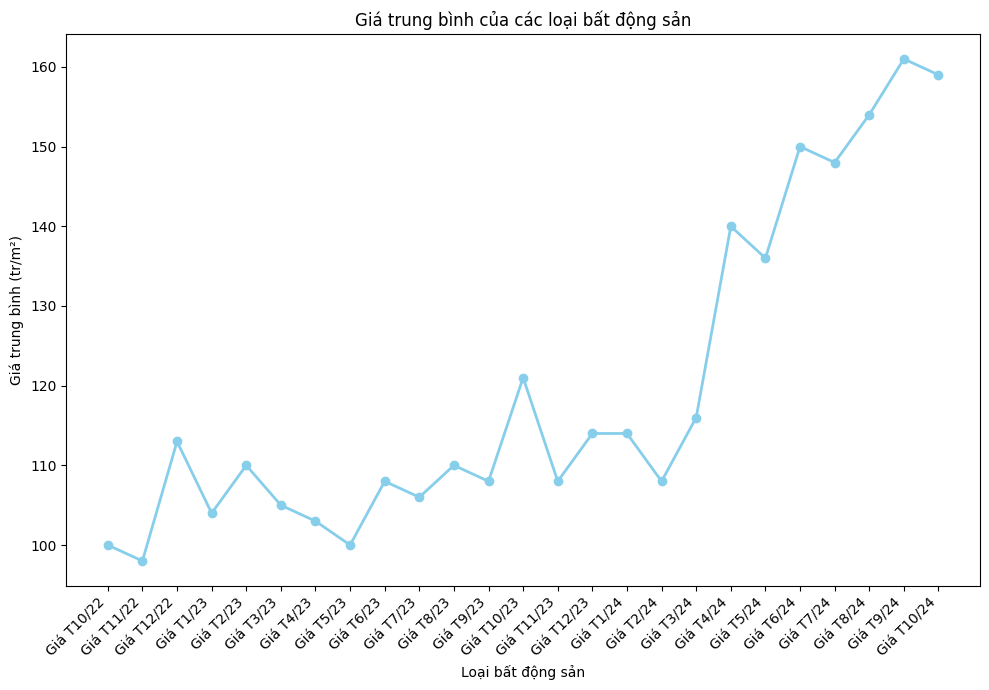

In [125]:
time_in_history = list(history_price.keys())
price_of_time = list(history_price.values())

# Tạo biểu đồ cột
plt.figure(figsize = (10, 7))  
plt.plot(time_in_history, price_of_time, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=6)
plt.xlabel('Loại bất động sản')  
plt.ylabel('Giá trung bình (tr/m²)')  
plt.title('Giá trung bình của các loại bất động sản')  
plt.xticks(rotation = 45, ha = 'right')  
plt.tight_layout()  

# Hiển thị biểu đồ
plt.show()